In [1]:
import torch
import os
import pickle
from pytorch3d.ops import knn_points, knn_gather
import os.path as osp
import matplotlib.pyplot as plt
from glob import glob

## Visualize the voting space

### Get the input

In [6]:
output_root = '/home/shimingwang/workspace/sf_tv/sceneflow_tv_se'
output_folder =  'outputs/sf_voxel_model_new_dst_src_m_32_n_64_voxel_01/25e5c600-36fe-3245-9cc0-40ef91620c22'

output_path = osp.join(output_root, output_folder)
print(output_path)
print
file_list = []
for file_name in glob(f'{output_path}/*.pkl'):
    file_list.append(file_name)

print(len(file_list))

/home/shimingwang/workspace/sf_tv/sceneflow_tv_se/outputs/sf_voxel_model_new_dst_src_m_32_n_64_voxel_01/25e5c600-36fe-3245-9cc0-40ef91620c22
156


In [7]:
index = 125

file_path = file_list[index]
print(file_path)

file_name = file_path.split('/')[-1]
print(file_name)

with open(file_path, 'rb') as f:
    outputs = pickle.load(f)

print(outputs.keys())   

/home/shimingwang/workspace/sf_tv/sceneflow_tv_se/outputs/sf_voxel_model_new_dst_src_m_32_n_64_voxel_01/25e5c600-36fe-3245-9cc0-40ef91620c22/315966116260259000.pkl
315966116260259000.pkl
dict_keys(['input_batch', 'model_output', 'final_flow'])


In [8]:
input_batch = outputs['input_batch']
print(input_batch.keys())

model_output = outputs['model_output'] 
print(model_output.keys())

voting_vol = model_output['voting_vol']

print(voting_vol.shape)

dict_keys(['scene_id', 'timestamp', 'pc0', 'gm0', 'pose0', 'pc1', 'gm1', 'pose1', 'flow', 'flow_is_valid', 'flow_category_indices', 'ego_motion', 'origin_pc0'])
dict_keys(['pseudoimages_src', 'pseudoimages_dst', 'pseudoimages_grid', 'feats_voxel_src', 'feats_voxel_dst', 'voxels_src', 'voting_vol', 'points_src_offset', 'points_src_voxel_idx', 'flow', 'pc0_points_lst', 'pc1_points_lst', 'pc0_valid_point_idxes', 'pc1_valid_point_idxes', 'pose_flow'])
torch.Size([19407, 42, 42])


In [9]:
print(input_batch['pc0'].shape)
print(input_batch['pc1'].shape)
print('gt_flow:', input_batch['flow'].shape)  
print(model_output['voting_vol'].shape)
print(model_output['points_src_voxel_idx'].shape)
print(model_output['pc0_valid_point_idxes'].shape)
print(model_output['pc0_points_lst'].shape)
print(model_output['points_src_offset'].shape)

print(model_output['pc0_valid_point_idxes'][:10], model_output['pc0_valid_point_idxes'].max())
print(model_output['points_src_voxel_idx'][:10], model_output['points_src_voxel_idx'].max())

torch.Size([69962, 3])
torch.Size([69784, 3])
gt_flow: torch.Size([95455, 3])
torch.Size([19407, 42, 42])
torch.Size([42692])
torch.Size([42692])
torch.Size([42692, 3])
torch.Size([42692, 3])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor(69961, device='cuda:0')
tensor([16949, 16086, 16086, 17000, 17048, 16132, 16111, 17100, 17128, 16160],
       device='cuda:0') tensor(19406, device='cuda:0')


In [10]:
flow = input_batch['flow']

flow = flow[model_output['pc0_valid_point_idxes']]
pose_flow = model_output['pose_flow'][model_output['pc0_valid_point_idxes']]
print(flow.shape)
print(pose_flow.shape)  


gt_flow = flow - pose_flow

torch.Size([42692, 3])
torch.Size([42692, 3])


### validate the gathering function

In [11]:
pc_src = input_batch['pc0'] ## after ground removal
valid_pts_mask = model_output['pc0_valid_point_idxes']
valid_pts = model_output['pc0_points_lst']
pts_src_offsets = model_output['points_src_offset']
pose_flow = model_output['pose_flow']


print(pc_src.shape)
print(valid_pts_mask.shape)
print(valid_pts.shape)
print(pts_src_offsets.shape)
print(pose_flow.shape)

pc_src_egm = pc_src + pose_flow 
valid_pts_from_mask = pc_src_egm[valid_pts_mask]
print(valid_pts_from_mask.shape)

print(valid_pts[:10, :])
print(valid_pts_from_mask[:10, :])
print(torch.eq(valid_pts, valid_pts_from_mask).all())

torch.Size([69962, 3])
torch.Size([42692])
torch.Size([42692, 3])
torch.Size([42692, 3])
torch.Size([69962, 3])
torch.Size([42692, 3])
tensor([[-38.4124,  32.8621,   0.5870],
        [-32.9824,  28.2517,  -2.5300],
        [-32.9355,  28.2522,  -1.5164],
        [-38.4768,  33.0803,  -0.5918],
        [-38.5716,  33.2045,   0.5909],
        [-33.1730,  28.6095,  -2.5520],
        [-32.9056,  28.4087,  -1.5191],
        [-38.6050,  33.4542,  -0.5957],
        [-38.6367,  33.5165,   0.5947],
        [-33.2061,  28.8280,  -2.5623]], device='cuda:0')
tensor([[-38.4124,  32.8621,   0.5870],
        [-32.9824,  28.2517,  -2.5300],
        [-32.9355,  28.2522,  -1.5164],
        [-38.4768,  33.0803,  -0.5918],
        [-38.5716,  33.2045,   0.5909],
        [-33.1730,  28.6095,  -2.5520],
        [-32.9056,  28.4087,  -1.5191],
        [-38.6050,  33.4542,  -0.5957],
        [-38.6367,  33.5165,   0.5947],
        [-33.2061,  28.8280,  -2.5623]], device='cuda:0')
tensor(False, device='cuda:0'

a heatmap for voting space

In [12]:
print(voting_vol.shape)

torch.Size([19407, 42, 42])


In [13]:
import numpy as np  

In [14]:
voting_vol_np = voting_vol.cpu().numpy()

print(voting_vol_np.shape)

selected_idxes = np.random.choice(voting_vol_np.shape[0], 16, replace=False)

selected_vols = voting_vol_np[selected_idxes,...]

print(selected_vols.shape)

(19407, 42, 42)
(16, 42, 42)


In [15]:
for vol_idx in range(voting_vol_np.shape[0]):
    vol = voting_vol_np[vol_idx, ...]
    # print(vol.shape)
    min_vol = vol.min()
    if min_vol < 0:
        print(vol_idx, min_vol)

13 -0.22507566
14 -0.26790965
17 -0.02489938
18 -0.0038149506
20 -0.2942852
21 -0.26441845
27 -0.0038149506
29 -0.26441845
30 -0.2790029
31 -0.599801
33 -0.26790965
34 -0.19944614
35 -0.2942852
36 -0.19944614
42 -0.2942852
43 -0.13617885
44 -0.19944614
45 -0.26790965
49 -0.5005282
50 -0.5005282
51 -0.22875382
52 -0.13617885
53 -0.19944614
54 -0.26790965
59 -0.2942852
60 -0.2942852
61 -0.599801
62 -0.22875382
63 -0.22875382
64 -0.22875382
65 -0.1683023
66 -0.26790965
72 -0.2790029
73 -0.2790029
74 -0.5005282
75 -0.599801
76 -0.26790965
77 -0.26790965
78 -0.26790965
88 -0.22875382
96 -0.26441845
103 -0.5005282
107 -0.5005282
108 -0.599801
113 -0.19946381
114 -0.599801
120 -0.5005282
121 -0.599801
122 -0.599801
123 -0.599801
126 -0.0038149506
127 -0.02489938
132 -0.34649658
133 -0.36473876
134 -0.26790965
135 -0.0038149506
140 -0.34649658
147 -0.0038149506
148 -0.0038149506
152 -0.26441845
153 -0.40619653
160 -0.26441845
161 -0.599801
162 -0.34649658
163 -0.0038149506
167 -0.61620486
168 

Text(0.5, 1.0, 'idx: 34, min: -0.1994, max: 15.8268')

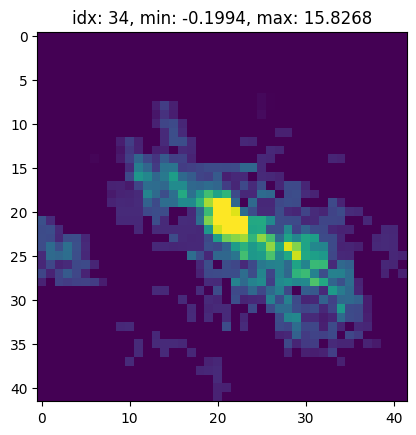

In [16]:
voting_example = voting_vol_np[34, ...]
plt.imshow(voting_example, vmin=0, vmax=8)
plt.axis('on')
plt.title(f'idx: 34, min: {voting_example.min():.4f}, max: {voting_example.max():.4f}')

In [60]:

voting_example = voting_vol_np[14019, ...].flatten()
topk_idx = np.argsort(voting_example)[::-1]

idx_list = []
for idx in topk_idx:
    idx_2d = (idx // 42, idx % 42)
    idx_list.append(idx_2d)
print(voting_example[topk_idx])
print(topk_idx)
print(idx_list)
print(voting_example[20*42+20])

[19.710855 18.709427 18.686682 ...  0.        0.        0.      ]
[ 811  809  810 ... 1237 1238    0]
[(19, 13), (19, 11), (19, 12), (20, 13), (20, 11), (20, 10), (20, 14), (20, 12), (19, 15), (19, 14), (19, 9), (19, 10), (20, 15), (20, 9), (20, 16), (19, 5), (19, 7), (19, 8), (19, 6), (20, 8), (19, 17), (19, 16), (19, 4), (20, 5), (20, 7), (20, 17), (20, 6), (19, 18), (20, 4), (18, 11), (18, 10), (18, 12), (20, 18), (19, 3), (19, 19), (18, 13), (18, 9), (18, 5), (18, 8), (18, 7), (18, 6), (20, 19), (20, 3), (19, 20), (18, 15), (18, 14), (18, 4), (21, 11), (21, 10), (21, 13), (20, 20), (21, 12), (21, 14), (21, 15), (19, 21), (19, 2), (19, 22), (18, 18), (18, 17), (18, 16), (20, 21), (21, 16), (21, 9), (19, 23), (20, 22), (19, 24), (20, 2), (18, 3), (18, 19), (20, 23), (21, 17), (20, 24), (19, 25), (21, 8), (19, 1), (18, 20), (18, 2), (20, 25), (21, 22), (21, 7), (21, 5), (19, 26), (19, 27), (19, 28), (19, 29), (19, 31), (19, 30), (19, 33), (19, 32), (21, 6), (19, 34), (20, 1), (19, 35)

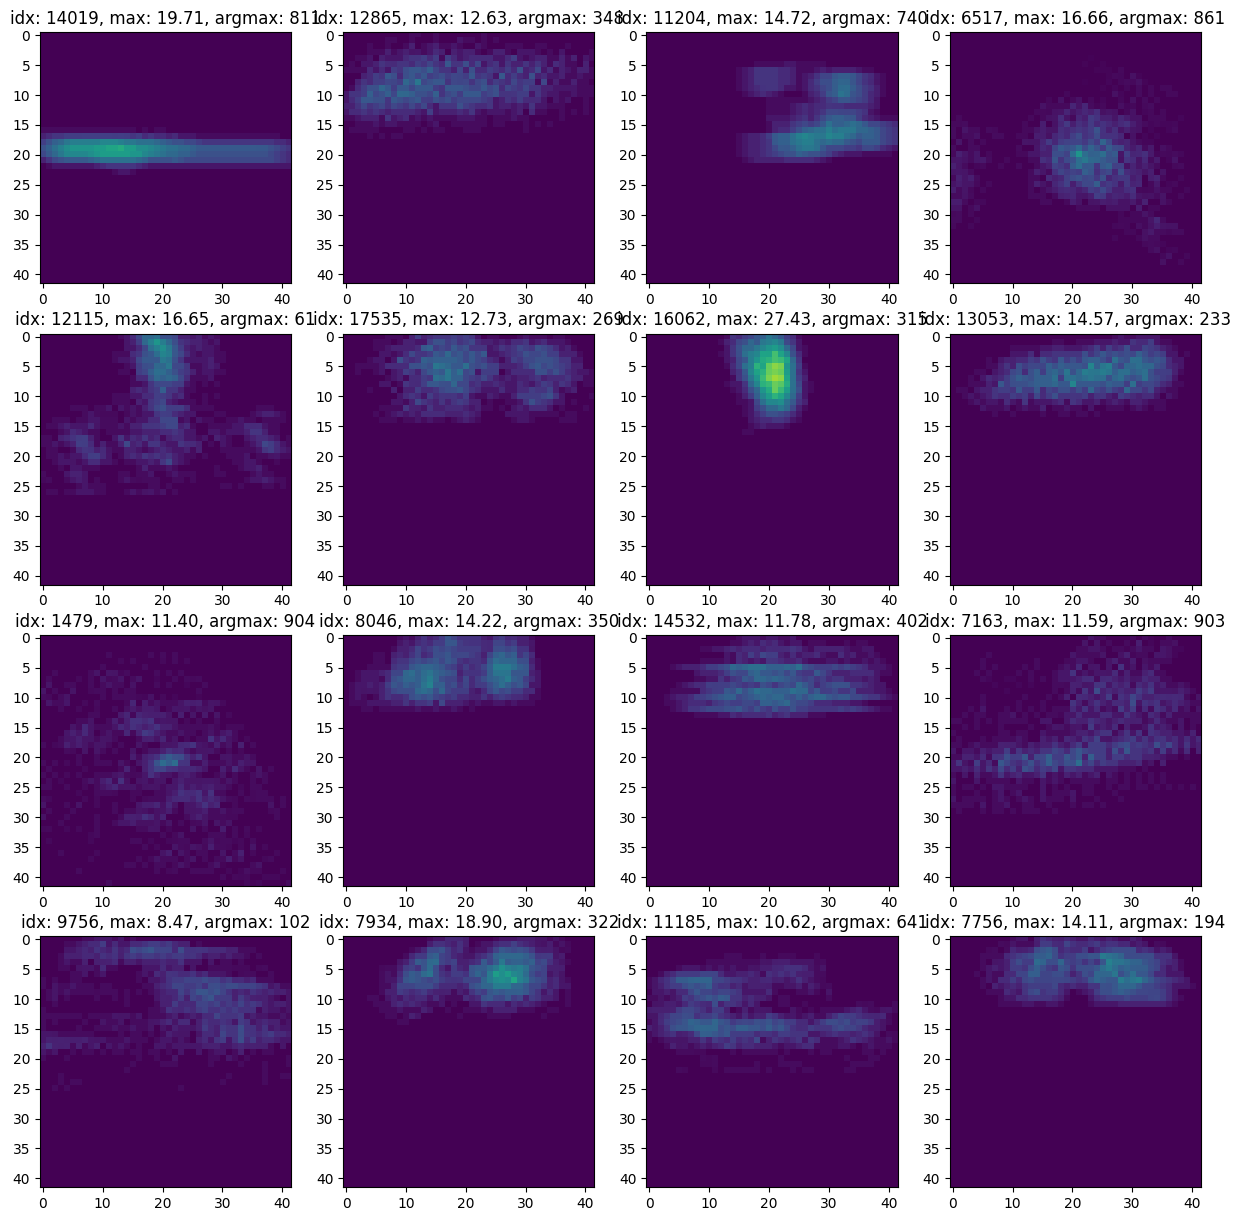

In [36]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(selected_vols[i*4+j, :, :], vmin=0, vmax=32)
        axs[i, j].axis('on')
        axs[i, j].set_title(f'idx: {selected_idxes[i*4+j]}, max: {selected_vols[i*4+j].max():.2f}, argmax: {selected_vols[i*4+j].argmax()}')


In [43]:
interesting_voxel_index = 14019

points_src_voxel_idx = model_output['points_src_voxel_idx']

print(points_src_voxel_idx.shape)

print(points_src_voxel_idx.max(), points_src_voxel_idx.min())

indices = (points_src_voxel_idx == interesting_voxel_index).nonzero()
print('indice:', len(indices), indices)

print('voxel:', points_src_voxel_idx[indices])

print(gt_flow.shape)

selected_gt_flow = gt_flow[indices, :]
print(selected_gt_flow.shape)
print(selected_gt_flow)

selected_gt_flow_xy = selected_gt_flow.squeeze(1)[:, :2]


print('selected points flow:', selected_gt_flow_xy)


print('selected points flow mean:', selected_gt_flow_xy.mean(dim=0))


valid_pts = model_output['pc0_points_lst']

selected_valid_pts = valid_pts[indices, :]
print('selected points:', selected_valid_pts)

torch.Size([42692])
tensor(19406, device='cuda:0') tensor(0, device='cuda:0')
indice: 1 tensor([[22844]], device='cuda:0')
voxel: tensor([[14019]], device='cuda:0')
torch.Size([42692, 3])
torch.Size([1, 1, 3])
tensor([[[0.0003, 0.0003, 0.0009]]], device='cuda:0')
selected points flow: tensor([[0.0003, 0.0003]], device='cuda:0')
selected points flow mean: tensor([0.0003, 0.0003], device='cuda:0')
selected points: tensor([[[-12.7058,  20.6115,   0.0307]]], device='cuda:0')


In [44]:
print(model_output.keys())

dict_keys(['pseudoimages_src', 'pseudoimages_dst', 'pseudoimages_grid', 'feats_voxel_src', 'feats_voxel_dst', 'voxels_src', 'voting_vol', 'points_src_offset', 'points_src_voxel_idx', 'flow', 'pc0_points_lst', 'pc1_points_lst', 'pc0_valid_point_idxes', 'pc1_valid_point_idxes', 'pose_flow'])


In [45]:
voxels_src= model_output['voxels_src']
print(voxels_src.shape)
print(voxels_src.max(0), voxels_src.min(0))
print(voxels_src[interesting_voxel_index, ...])

# 512/512
def voxel2dis(voxel):
    y =  0.2 * voxel[0] + -51.2
    x = 0.2 * voxel[1] + -51.2
    
    print(x, y)
    
voxel2dis(voxels_src[interesting_voxel_index, ...])

torch.Size([19407, 2])
torch.return_types.max(
values=tensor([1023, 1023], device='cuda:0', dtype=torch.int32),
indices=tensor([19387,  4576], device='cuda:0')) torch.return_types.min(
values=tensor([0, 0], device='cuda:0', dtype=torch.int32),
indices=tensor([    0, 13400], device='cuda:0'))
tensor([718, 384], device='cuda:0', dtype=torch.int32)
tensor(25.6000, device='cuda:0') tensor(92.4000, device='cuda:0')


In [46]:
%matplotlib inline
def visual_pc(pc,
                l,
                eval_range=54):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
    ax.set_facecolor('white')
    # ax.tick_params(left = False,
    #             right = False ,
    #             labelleft = False ,
    #             labelbottom = False,
    #             bottom = False)

    dists = np.sqrt(np.sum(pc[:, :2] ** 2, axis=1))
    # colors = np.minimum(1, dists / eval_range)
    ax.scatter(pc[ :,0], pc[ :,1], c='black', s=0.2)

    ax.scatter(pc[l, 0], pc[l, 1], c='red', s=20)
    print(pc[l])
    print(pc[l].shape)
    # Show ego vehicle.
    ax.plot(0, 0, 'x', color='black')
    ax.grid(True)
    ax.set_axis_on()
    axes_limit = eval_range  # Slightly bigger to include boxes that extend beyond the range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    

    plt.show()

In [47]:
pc_src = input_batch['pc0']
ego_flow = model_output['pose_flow']

pc_src_emc = pc_src + ego_flow

valid_pc = model_output['pc0_points_lst']

print(pc_src_emc.shape)
print(valid_pc.shape)

print(indices.shape)

torch.Size([69962, 3])
torch.Size([42692, 3])
torch.Size([1, 1])


(1,)
[[-12.705773    20.611473     0.03071049]]
(1, 3)


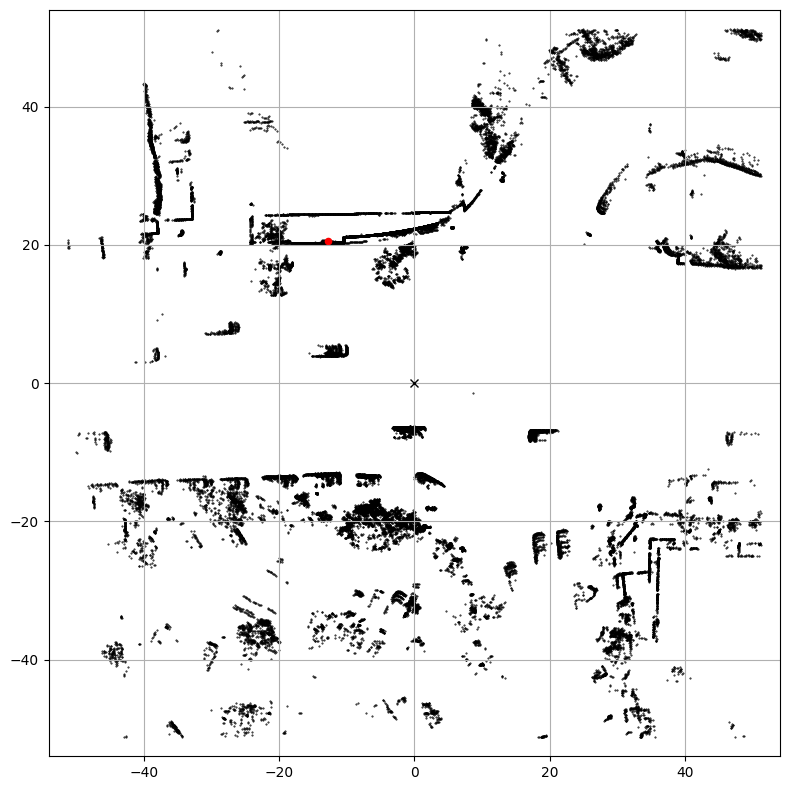

tensor([[-12.7058,  20.6115,   0.0307]], device='cuda:0')


In [48]:
l = indices[:,0].cpu().numpy()
print(l.shape)
visual_pc(valid_pc.cpu().numpy(), l=l)

print(valid_pc[l])

In [51]:
%matplotlib inline
def visual_pc_3d(pc,
                 pillar_pos,
                 l,
              eval_range=54):
    # fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True, projection='3d')
    
    fig = plt.figure(figsize=(8, 8), tight_layout=True,)
    ax = fig.add_subplot(projection='3d')
    ax.set_facecolor('white')
    ax.tick_params(left = False,
                right = False ,
                labelleft = False ,
                labelbottom = False,
                bottom = False)

    dists = np.sqrt(np.sum(pc[:, :2] ** 2, axis=1))
    colors = np.minimum(1, dists / eval_range)
    # ax.scatter(pc[ :,0], pc[ :,1], pc[:,2], c=colors, cmap='viridis')
    ax.scatter(pc[l, 0], pc[l, 1], pc[l,2], c='red', s=50)
    print(pc[l])
    
    p_mask_x = np.logical_and(pc[:, 0] < pillar_pos[0]+0.2, pc[:, 0] >pillar_pos[0]-0.2)
    p_mask_y = np.logical_and(pc[:, 1] < pillar_pos[1]+0.2, pc[:, 1] >pillar_pos[1]-0.2)

    p_mask = np.logical_and(p_mask_x, p_mask_y)
    
    pc = pc[p_mask]
    print(pc.shape)
    print(pc)
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], c='black', alpha=0.5, s=10)

    # Show ego vehicle.
    ax.plot(0, 0, 'x', color='black')
    axes_limit = eval_range  # Slightly bigger to include boxes that extend beyond the range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    
    plt.show()

torch.Size([1, 3])
[[-12.705773    20.611473     0.03071049]]
(30, 3)
[[-1.28372507e+01  2.04541092e+01  2.79742301e-01]
 [-1.27277470e+01  2.04394150e+01  2.79742211e-01]
 [-1.26578360e+01  2.04868889e+01  2.79739469e-01]
 [-1.25799789e+01  2.05188007e+01  2.79737413e-01]
 [-1.25659561e+01  2.07063732e+01 -8.46736431e-01]
 [-1.27511902e+01  2.04391708e+01 -7.02191293e-01]
 [-1.26113672e+01  2.05341129e+01 -7.02196777e-01]
 [-1.28060074e+01  2.04543362e+01 -5.62054873e-01]
 [-1.28542051e+01  2.06102085e+01 -5.38377208e-04]
 [-1.27360964e+01  2.05018082e+01 -5.62057614e-01]
 [-1.27129211e+01  2.05332813e+01 -5.35774685e-04]
 [-1.26105690e+01  2.04403725e+01 -5.60102522e-01]
 [-1.26430101e+01  2.05807533e+01 -5.38513355e-04]
 [-1.25406580e+01  2.04878426e+01 -5.60105264e-01]
 [-1.28526173e+01  2.04226761e+01 -8.12053025e-01]
 [-1.26661835e+01  2.05492935e+01 -2.49560297e-01]
 [-1.26664524e+01  2.05805149e+01 -8.13038409e-01]
 [-1.25962715e+01  2.05967655e+01 -2.49563038e-01]
 [-1.2517355

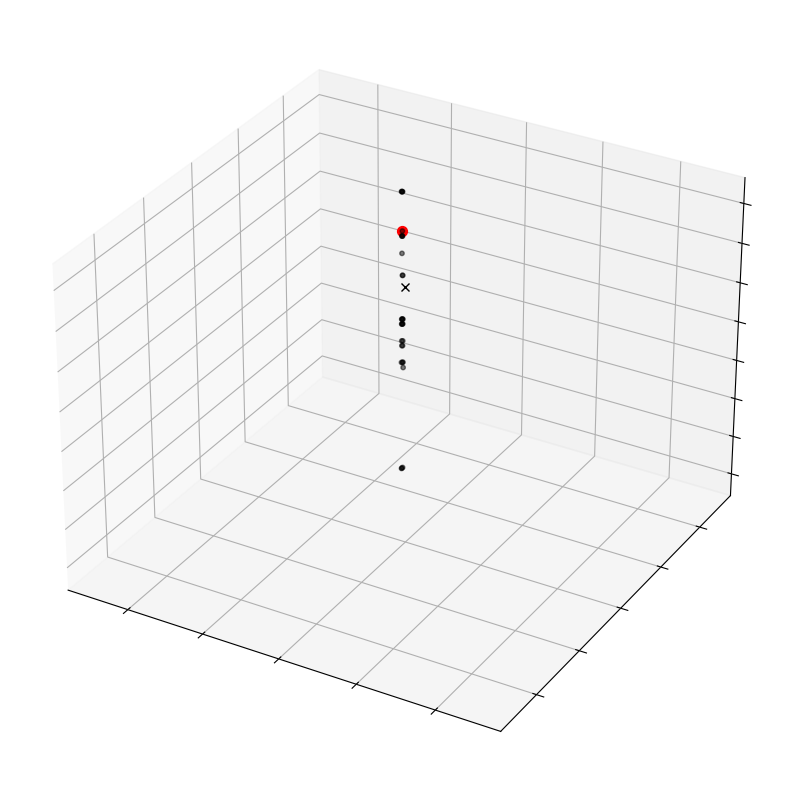

tensor([[-12.7058,  20.6115,   0.0307]], device='cuda:0')


In [52]:
print(valid_pc[l].shape)
pillar_pose = valid_pc[l].cpu().numpy()
visual_pc_3d(valid_pc.cpu().numpy(), pillar_pos=pillar_pose[0],l =l)

print(valid_pc[l])

torch.Size([32, 1024, 1024])
torch.Size([1024, 1024])
x=384, y=718


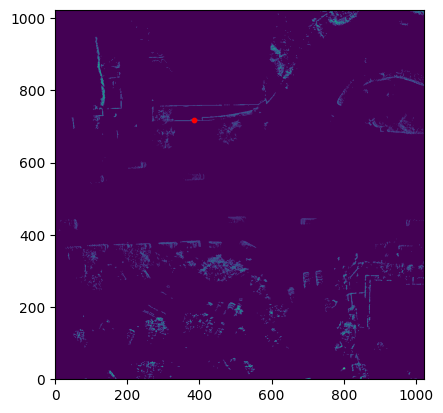

In [53]:
voxel_feats_src = model_output['pseudoimages_src']
print(voxel_feats_src.shape)

voxel_feats_src_mean = voxel_feats_src.mean(dim=0)
print(voxel_feats_src_mean.shape)
plt.imshow(voxel_feats_src_mean.cpu().numpy(), cmap='viridis')
y,x = voxels_src[interesting_voxel_index, ...].cpu().numpy()

print(f'x={x}, y={y}')
plt.scatter(x, y, c='red', s=10)
# plt.scatter(0, 9, c='red', s=10)
plt.gca().invert_yaxis()


### random check

### get the Rough Flow of the voting space

In [30]:
ref_y, ref_x = torch.meshgrid(torch.linspace(-3.3, 3.3, 34),torch.linspace(-3.3, 3.3 , 34))

print(ref_y.shape)
print(ref_x.shape)

flow_coord = torch.stack((ref_y, ref_x), dim=-1)

print(flow_coord.shape)

print(flow_coord[0, 0, :])
print(flow_coord[0, -1, :])
print(flow_coord[-1, 0, :])
print(flow_coord[-1, -1, :])

flow_coord = flow_coord.view(-1, 2)
print(flow_coord.shape)

torch.Size([34, 34])
torch.Size([34, 34])
torch.Size([34, 34, 2])
tensor([-3.3000, -3.3000])
tensor([-3.3000,  3.3000])
tensor([ 3.3000, -3.3000])
tensor([3.3000, 3.3000])
torch.Size([1156, 2])


In [31]:
print(voting_vol.shape)

vols_flattened = voting_vol.view(voting_vol.shape[0], -1)
print(vols_flattened.shape)

topk_voting, topk_idx = torch.topk(vols_flattened, 5, dim=-1)
print(topk_voting.shape)
print(topk_idx.shape)

gathered_vol = torch.gather(vols_flattened, dim =1, index = topk_idx)

print(torch.eq(gathered_vol, topk_voting).all())    


print(topk_voting[:20, :])
print(topk_voting.max(), topk_voting.min())

torch.Size([11264, 20, 20])
torch.Size([11264, 400])
torch.Size([11264, 5])
torch.Size([11264, 5])
tensor(True, device='cuda:0')
tensor([[1.0000, 0.7954, 0.6835, 0.6756, 0.0000],
        [1.9494, 1.0000, 0.9650, 0.9554, 0.9353],
        [1.9494, 1.0000, 0.9650, 0.9554, 0.9353],
        [1.9494, 1.0000, 0.9650, 0.9554, 0.9353],
        [6.8085, 6.1283, 6.0842, 6.0490, 6.0057],
        [1.8735, 1.8042, 1.7057, 1.6969, 1.6582],
        [2.7910, 2.6035, 2.6011, 2.5145, 2.0863],
        [3.5890, 2.6796, 2.5660, 2.5239, 2.4871],
        [3.5425, 3.4865, 2.7612, 2.7513, 2.7250],
        [3.5425, 3.4865, 2.7612, 2.7513, 2.7250],
        [6.0000, 5.4964, 4.7004, 4.5437, 4.3898],
        [6.0000, 5.4964, 4.7004, 4.5437, 4.3898],
        [1.4537, 1.4230, 1.0000, 0.8589, 0.8359],
        [1.4537, 1.4230, 1.0000, 0.8589, 0.8359],
        [6.8465, 6.6096, 6.6026, 6.0000, 5.6761],
        [6.8085, 6.1283, 6.0842, 6.0490, 6.0057],
        [6.8085, 6.1283, 6.0842, 6.0490, 6.0057],
        [1.9729, 1.87

### get the corresponding rough flow

In [32]:
print(flow_coord.shape, flow_coord.device)
print(topk_idx.shape, topk_idx.device)

flow_coord = flow_coord.to(topk_idx.device)
voting_rough_flow = knn_gather(x=flow_coord[None], idx=topk_idx[None])

print(voting_rough_flow.shape)

voting_rough_flow = voting_rough_flow.squeeze(0)


torch.Size([1156, 2]) cpu
torch.Size([11264, 5]) cuda:0
torch.Size([1, 11264, 5, 2])


In [33]:
voting_rough_flow_distance = torch.norm(voting_rough_flow, dim=-1)
print(voting_rough_flow_distance.shape)
print(voting_rough_flow_distance.max(), voting_rough_flow_distance.min())

voting_rough_flow_distance_top1 = voting_rough_flow_distance[:, 0]

print(voting_rough_flow_distance_top1.shape)
print(voting_rough_flow_distance_top1.max(), voting_rough_flow_distance_top1.min())

torch.Size([11264, 5])
tensor(4.6669, device='cuda:0') tensor(1.1045, device='cuda:0')
torch.Size([11264])
tensor(4.6669, device='cuda:0') tensor(1.1045, device='cuda:0')


### project back to the points level

In [34]:
points_src_voxel_idx = model_output['points_src_voxel_idx']

print(voting_rough_flow_distance[None].shape)
print(points_src_voxel_idx[None,:,None].shape)
points_src_rough_flow_dist = knn_gather(x=voting_rough_flow_distance[None], idx=points_src_voxel_idx[None,:,None])

print(points_src_rough_flow_dist.shape)

points_src_rough_flow_dist_top1 = points_src_rough_flow_dist.squeeze(0).squeeze(1)[:, 0]

print(points_src_rough_flow_dist_top1.shape)

print(points_src_rough_flow_dist_top1.max(), points_src_rough_flow_dist_top1.min())

torch.Size([1, 11264, 5])
torch.Size([1, 42170, 1])


RuntimeError: gather(): Expected dtype int64 for index

In [35]:
import numpy as np

### Get histogram of the voting space

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4. ]


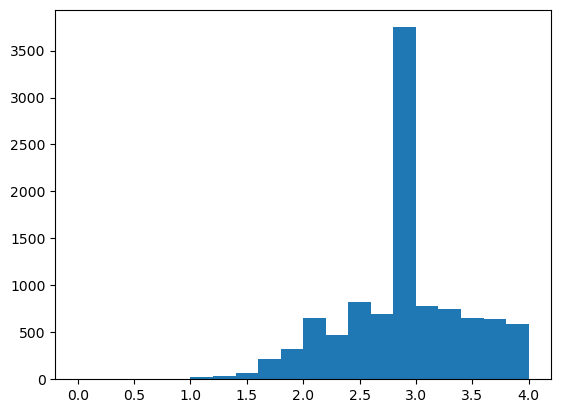

In [36]:
bins = np.linspace(0, 4, 21)

print(bins)

counts, bins = np.histogram(voting_rough_flow_distance_top1.cpu().numpy(), bins=bins)
plt.stairs(counts, bins, fill=True)

### Get histogram of point levels

In [37]:
bins = np.linspace(0, 4, 21)

print(bins)

counts, bins = np.histogram(points_src_rough_flow_dist_top1.cpu().numpy(), bins=bins)
plt.stairs(counts, bins, fill=True)

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4. ]


NameError: name 'points_src_rough_flow_dist_top1' is not defined

### Histogram of gt flow

torch.Size([45371, 3])
torch.Size([45371])
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4. ]


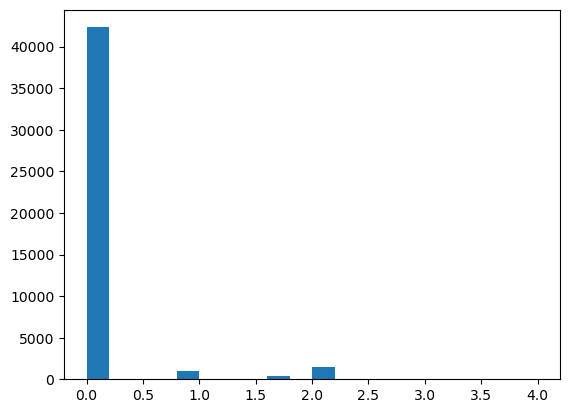

In [33]:
print(gt_flow.shape)

gt_flow_distance = torch.norm(gt_flow, dim=-1)

print(gt_flow_distance.shape)

bins = np.linspace(0, 4, 21)

print(bins)

counts, bins = np.histogram(gt_flow_distance.cpu().numpy(), bins=bins)
plt.stairs(counts, bins, fill=True)

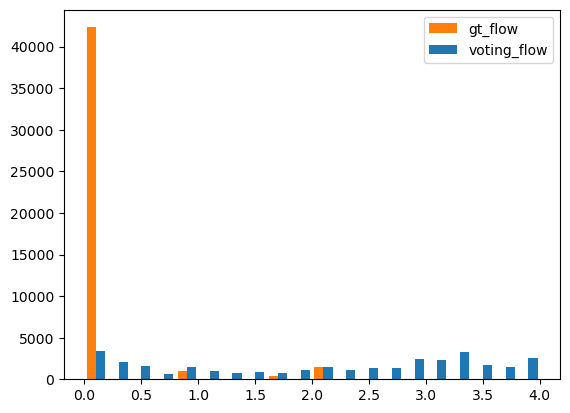

In [34]:
fig, ax = plt.subplots()    

gt_flow = gt_flow_distance.cpu().numpy()
voting_flow = points_src_rough_flow_dist_top1.cpu().numpy()
ax.hist((gt_flow, voting_flow), bins=bins, histtype='bar', color=['C1', 'C0'], label=['gt_flow', 'voting_flow'])
ax.legend(prop={'size': 10})

## A for loop for all the samples

In [38]:
ref_y, ref_x = torch.meshgrid(torch.linspace(-3.3, 3.3, 34),torch.linspace(-3.3, 3.3 , 34))

print(ref_y.shape)
print(ref_x.shape)

flow_coord = torch.stack((ref_y, ref_x), dim=-1)

print(flow_coord.shape)

print(flow_coord[0, 0, :])
print(flow_coord[0, -1, :])
print(flow_coord[-1, 0, :])
print(flow_coord[-1, -1, :])

flow_coord = flow_coord.view(-1, 2)
print(flow_coord.shape)

torch.Size([34, 34])
torch.Size([34, 34])
torch.Size([34, 34, 2])
tensor([-3.3000, -3.3000])
tensor([-3.3000,  3.3000])
tensor([ 3.3000, -3.3000])
tensor([3.3000, 3.3000])
torch.Size([1156, 2])


In [39]:
from tqdm import tqdm

In [40]:
voting_flow_list = []
gt_flow_list = []

for file_path in tqdm(file_list):
    # print(file_path)
    f = open(file_path, 'rb')
    outputs = pickle.load(f)
    f.close()

    input_batch = outputs['input_batch']
    model_output = outputs['model_output']
    
    voting_vol = model_output['voting_vol'].cpu()
    pc0_valid_point_idxes = model_output['pc0_valid_point_idxes'].cpu()
    points_src_voxel_idx = model_output['points_src_voxel_idx'].cpu()
    
    flow = input_batch['flow'][pc0_valid_point_idxes].cpu()
    pose_flow = model_output['pose_flow'][pc0_valid_point_idxes].cpu()

    gt_flow = flow - pose_flow
    

    vols_flattened = voting_vol.view(voting_vol.shape[0], -1)

    topk_voting, topk_idx = torch.topk(vols_flattened, 5, dim=-1)

    flow_coord = flow_coord.to(topk_idx.device)
    
    voting_rough_flow = knn_gather(x=flow_coord[None], idx=topk_idx[None])
    
    voting_rough_flow_distance = torch.norm(voting_rough_flow, dim=-1)
    
    mask = points_src_voxel_idx[None,:,None] > 0
    fill_value = -1
    
    idx = points_src_voxel_idx[None,:,None].long()
    idx[~mask] = 0
    
    points_src_rough_flow_dist = knn_gather(x=voting_rough_flow_distance, idx=idx)
    
    points_src_rough_flow_dist[~mask] = fill_value
    
    points_src_rough_flow_dist_top1 = points_src_rough_flow_dist.squeeze(0).squeeze(1)[:, 0]
    gt_flow_distance = torch.norm(gt_flow, dim=-1)

    gt_flow_ = gt_flow_distance.numpy()
    voting_flow_ = points_src_rough_flow_dist_top1.cpu().numpy()
    
    # assert len(gt_flow_) == len(voting_flow_), f'gt flow:,{len(gt_flow_)}, voting flow: {len(voting_flow_)}, {file_path}'
    gt_flow_list.append(gt_flow_)
    voting_flow_list.append(voting_flow_)


  0%|          | 0/156 [00:00<?, ?it/s]

100%|██████████| 156/156 [00:33<00:00,  4.63it/s]


In [14]:
import numpy as np

In [15]:
print(len(gt_flow_list))
print(len(voting_flow_list))

gt_flow_val_demo = np.concatenate(gt_flow_list, axis=0)
voting_flow_val_demo = np.concatenate(voting_flow_list, axis=0)

print(gt_flow_val_demo.shape)
print(voting_flow_val_demo.shape)

156
156
(6865751,)
(6883187,)


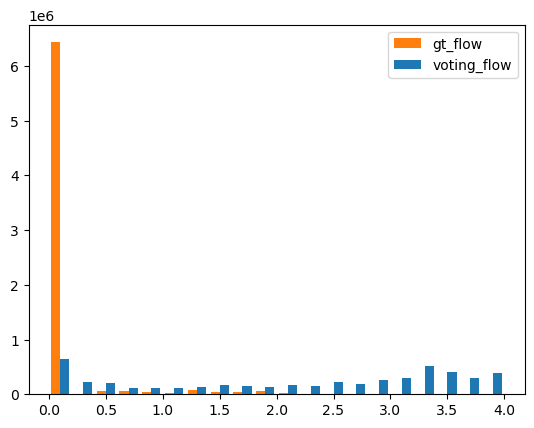

In [17]:
fig, ax = plt.subplots()    
bins = np.linspace(0, 4, 21)
ax.hist((gt_flow_val_demo, voting_flow_val_demo), bins=bins, histtype='bar', color=['C1', 'C0'], label=['gt_flow', 'voting_flow'])
ax.legend(prop={'size': 10})